In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass

/tmp/ipykernel_15635/1874044763.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv("./cutting/r800.csv", header=None)
data.columns = ["width", "height", "value"]

In [69]:
@dataclass
class Box:
    x1: float
    y1: float
    x2: float
    y2: float
    value: float
    
    @property
    def middle(self):
        return (self.x1 + self.x2) / 2, (self.y1 + self.y2) / 2

    @property
    def box(self):
        return self.x1, self.y1, self.x2, self.y2

    @property
    def height(self):
        return self.y2 - self.y1

    @property
    def width(self):
        return self.x2 - self.x1

    @property
    def top_left(self):
        return self.x1, self.y1

    @property
    def top_right(self):
        return self.x2, self.y1

    @property
    def bottom_left(self):
        return self.x1, self.y2

    @property
    def bottom_right(self):
        return self.x2, self.y2

    @property
    def verticies(self):
        return [self.top_left, self.top_right, self.bottom_right, self.bottom_left]

    @staticmethod
    def from_point(x, y, width, height, value):
        return Box(x, y, x + width, y + height, value)

    def guassian_mutate(self, sigma: float = 0.1):
        point_noise = np.random.normal(0, sigma, 2)
        point = np.array(self.top_left)
        new_point = point + point_noise
        return Box.from_point(new_point[0], new_point[1], self.width, self.height, self.value)

In [70]:
def iou(box1: Box, box2: Box):
    x1 = max(box1.x1, box2.x1)
    y1 = max(box1.y1, box2.y1)
    x2 = min(box1.x2, box2.x2)
    y2 = min(box1.y2, box2.y2)

    intersection_width = max(0, x2 - x1)
    intersection_height = max(0, y2 - y1)

    if intersection_width == 0 or intersection_height == 0:
        return 0
    
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    union_area = (box1.x2 - box1.x1) * (box1.y2 - box1.y1) + (box2.x2 - box2.x1) * (box2.y2 - box2.y1) - intersection_area
    return intersection_area / union_area

In [71]:
def radius_check(box: Box, radius):
    r = np.sqrt(np.sum(np.array(box.verticies) ** 2, axis=1))
    return np.all(r <= radius)

In [72]:
def random_point_inside_circle(radius):
    r = radius * np.sqrt(np.random.random())
    theta = np.random.random() * 2 * np.pi
    x = 0 + r * np.cos(theta)
    y = 0 + r * np.sin(theta)
    return x, y

In [73]:
def check(boxes: list[Box], new_box: Box):
    if not radius_check(new_box, 800):
        return False

    for box in boxes:
        if iou(box, new_box) > 0:
            return False
    return True

In [74]:
from typing import Literal

MUTATION_TYPE = Literal["gaussian", "add", "delete"]

@dataclass
class Individial:
    boxes: list[Box]

    @property
    def score(self):
        return sum([box.value for box in self.boxes])

    def mutate(self, mutation_type: MUTATION_TYPE) -> 'Individial':
        if mutation_type == "gaussian":
            if len(self.boxes) == 0:
                return self
            box_idx = int(np.random.randint(len(self.boxes)))
            boxes = self.boxes.copy()
            new_box = boxes.pop(box_idx).guassian_mutate()
            if check(boxes, new_box):
                boxes.append(new_box)
                return Individial(boxes)

            return self

        if mutation_type == "add":
            point = random_point_inside_circle(800)
            box_type = data.sample()
            width, height, value = int(box_type.width), int(box_type.height), int(box_type.value)

            new_box = Box.from_point(point[0], point[1], width, height, value)

            if check(self.boxes, new_box):
                return Individial(self.boxes + [new_box])

            return self

        if mutation_type == "delete":
            idx = int(np.random.randint(len(self.boxes)))
            boxes = self.boxes.copy()
            boxes.pop(idx)
            return Individial(boxes)

In [75]:
def crossover(ind1: Individial, ind2: Individial) -> Individial:
    boxes_left = [
        box for box in ind1.boxes if box.middle[0] < 0
    ]
    boxes = boxes_left.copy()
    for box in ind2.boxes:
        if box.middle[0] >= 0:
            if check(boxes, box):
                boxes.append(box)

    return Individial(boxes)

In [76]:
def base_fig():
    figure, axes = plt.subplots()

    circle = plt.Circle((0, 0), 800, color="red", fill=False)

    figure.set_figwidth(6)
    figure.set_figheight(6)

    axes.add_artist(circle)
    axes.set_aspect(1)
    axes.set_xlim(-1000, 1000)
    axes.set_ylim(-1000, 1000)
    return figure, axes

In [77]:
def draw_individial(individual: Individial):
    fig, ax = base_fig()
    for box in individual.boxes:
        ax.add_patch(plt.Rectangle(box.top_left, box.width, box.height, color="blue", alpha=0.5))

    return fig, ax


In [78]:
from IPython.display import display, clear_output

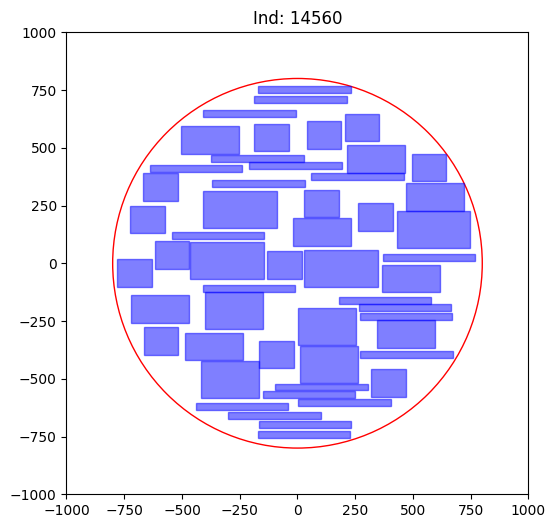

CPU times: user 5.53 s, sys: 156 ms, total: 5.69 s
Wall time: 5.68 s


In [80]:
%%time
ind = Individial([])
for _ in range(10_000):
    if np.random.random() < 0.5:
        ind = ind.mutate("add")
    else:
        ind = ind.mutate("gaussian")

fig, ax = draw_individial(ind)
ax.set_title(f"Ind: {ind.score}")
display(fig)
clear_output(wait = True)
plt.pause(0.2)